In [1]:
""" sheet1_implementation.py

PUT YOUR NAME HERE:
Boris Bubla
Leonard Paeleke


Write the functions
- pca
- gammaidx
- lle
Write your implementations in the given functions stubs!


(c) Daniel Bartz, TU Berlin, 2013
"""


' sheet1_implementation.py\n\nPUT YOUR NAME HERE:\nBoris Bubla\nLeonard Paeleke\n\n\nWrite the functions\n- pca\n- gammaidx\n- lle\nWrite your implementations in the given functions stubs!\n\n\n(c) Daniel Bartz, TU Berlin, 2013\n'

In [2]:
import numpy as np
import scipy.linalg as la
import scipy.spatial as sp
import matplotlib.pyplot as plt

In [9]:
X = np.array([[ -2.133268233289599,   0.903819474847349,   2.217823388231679, -0.444779660856219,
                -0.661480010318842,  -0.163814281248453,  -0.608167714051449,  0.949391996219125],
            [ -1.273486742804804,  -1.270450725314960,  -2.873297536940942,   1.819616794091556,
              -2.617784834189455,   1.706200163080549,   0.196983250752276,   0.501491995499840],
            [ -0.935406638147949,   0.298594472836292,   1.520579082270122,  -1.390457671168661,
              -1.180253547776717,  -0.194988736923602,  -0.645052874385757,  -1.400566775105519]]).T
m = 2;

In [10]:
class PCA():
    """
        Definition of PCA Class
        Algorithms in guide.pdf used, pg 15-17
    """
    def __init__(self, Xtrain):
        """
            Compute Principal Components
        """
        # 1. centre data
        self.Xmean = np.mean(Xtrain, axis = 0)
        self.C = Xtrain - self.Xmean
        # 2. generate covariance marix
        self.C = np.cov(self.C.T)
        # 3. calculate eigenvalues and eigenvectors
        self.D, self.U = np.linalg.eig(self.C)
        # Make a list of (eigenvalue, eigenvector) tuples
        self.pairs = [(np.abs(self.D[i]), self.U[i]) for i in range(len(self.D))]
        # Sort the (eigenvalue, eigenvector) tuples from high to low
        self.pairs.sort()
        self.pairs.reverse()
        
        self.U = -1*np.array([self.pairs[i][1] for i in range(len(self.pairs))]) # eigencevtors CAVEAT: mulitplying by -1 because numpy.eig routine delivers wrong sign
        self.D = np.array([self.pairs[i][0] for i in range(len(self.pairs))]) # eigenvalues
    def project(self, Xtest, m):
        """
            Projecting to the low-dimensional sub-space
        """
        # 1. centre data by mean of training
        Xtest = Xtest - self.Xmean
        # 2. project data to m principal components
        Z = self.U.T[range(m)].dot(Xtest.T).T    
        return Z
    def denoise(self, Xtest, m):
        """
            Reconstructing projected data points in the original space
        """
        # 1. projection to the low-dimencsional sub-space
        Z = self.project(Xtest, m)
        # 2. recontraction by m dimensions
        Y = Z.dot(pca1.U.T[range(m)])+self.Xmean
        return Y

In [11]:
pca1 = PCA(X)

In [12]:
Z = pca1.project(X,m)
Z

array([[-0.26424835,  2.25344912],
       [ 1.29695602, -0.60127941],
       [ 3.59711235, -1.28967825],
       [-2.45930604, -0.45229125],
       [ 1.33335186,  1.82830153],
       [-1.82020954, -1.04090645],
       [-0.85747383,  0.21347615],
       [-0.82618248, -0.91107143]])

In [13]:
Y = pca1.denoise(X,m)
Y

array([[-1.88406616, -1.35842791, -1.38087939],
       [ 0.96048487, -1.28976527,  0.19729962],
       [ 2.34965134, -2.91823143,  1.28492391],
       [-0.53132686,  1.84911663, -1.23574621],
       [-0.96141012, -2.51555289, -0.64409954],
       [ 0.17114282,  1.59202918, -0.79375686],
       [-0.47605492,  0.15195227, -0.88121723],
       [ 0.43110399,  0.67815178, -0.47407698]])

In [3]:
X = np.array([  [   0.5376671395461, -2.25884686100365, 0.318765239858981, -0.433592022305684, 3.57839693972576,
                    -1.34988694015652, 0.725404224946106, 0.714742903826096, -0.124144348216312, 1.40903448980048,
                    0.67149713360808, 0.717238651328838, 0.488893770311789, 0.726885133383238, 0.293871467096658,
                    0.888395631757642, -1.06887045816803, -2.9442841619949, 0.325190539456198, 1.37029854009523],
                [   1.83388501459509, 0.862173320368121, -1.30768829630527, 0.34262446653865, 2.76943702988488,
                    3.03492346633185, -0.0630548731896562, -0.204966058299775, 1.48969760778546, 1.41719241342961,
                    -1.20748692268504, 1.63023528916473, 1.03469300991786, -0.303440924786016, -0.787282803758638,
                    -1.14707010696915, -0.809498694424876, 1.4383802928151, -0.754928319169703, -1.7115164188537]]).T

k = 3;

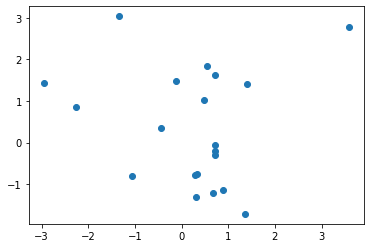

In [4]:
plt.plot(X.T[0],X.T[1], 'o')

In [274]:
z = np.array([complex(c[0], c[1]) for c in X])
m, n = np.meshgrid(z, z)
# get the distance via the norm
D = abs(m-n)
D

array([[0.        , 2.960526  , 3.14919052, 1.77966356, 3.18139832,
        2.2372648 , 1.90620727, 2.04652621, 0.74596207, 0.96587462,
        3.04431499, 0.27151269, 0.8006789 , 2.14568535, 2.63248116,
        3.00151694, 3.09328959, 3.50434143, 2.5975182 , 3.64186029],
       [2.960526  , 0.        , 3.36932984, 1.89775821, 6.14093397,
        2.3552179 , 3.12438822, 3.15927564, 2.22502619, 3.70963607,
        3.58753529, 3.07359792, 2.75315122, 3.20519143, 3.03925589,
        3.73392481, 2.05195789, 0.8954545 , 3.048322  , 4.44910949],
       [3.14919052, 3.36932984, 0.        , 1.81371819, 5.21997603,
        4.65216907, 1.30937681, 1.1716632 , 2.83223177, 2.93490407,
        0.36668802, 2.96482311, 2.34855145, 1.08400859, 0.52100055,
        0.59184203, 1.47435603, 4.26478418, 0.55279732, 1.12640998],
       [1.77966356, 1.89775821, 1.81371819, 0.        , 4.6888671 ,
        2.84395328, 1.22794464, 1.27221401, 1.18808024, 2.13306557,
        1.90369834, 1.72694901, 1.15322977, 1

In [5]:
D = sp.distance_matrix(X, X)

In [8]:
pairs = [list(zip(np.linspace(0,len(X)-1,len(X)), D[i])) for i in range(len(X))]
Y = pairs[0]

In [9]:
Y

[(0.0, 0.0),
 (1.0, 2.960525995827129),
 (2.0, 3.1491905165372387),
 (3.0, 1.7796635585611749),
 (4.0, 3.1813983232241485),
 (5.0, 2.2372647957611633),
 (6.0, 1.9062072686629057),
 (7.0, 2.0465262089061764),
 (8.0, 0.7459620743312859),
 (9.0, 0.9658746207222721),
 (10.0, 3.0443149850476576),
 (11.0, 0.27151268572904474),
 (12.0, 0.8006789006127712),
 (13.0, 2.145685349799238),
 (14.0, 2.6324811607831724),
 (15.0, 3.0015169351561313),
 (16.0, 3.0932895897379606),
 (17.0, 3.504341429035323),
 (18.0, 2.5975181967917274),
 (19.0, 3.6418602902199773)]

In [10]:
Y = np.array(sorted(Y, key=lambda x: x[1]))
Y

array([[ 0.        ,  0.        ],
       [11.        ,  0.27151269],
       [ 8.        ,  0.74596207],
       [12.        ,  0.8006789 ],
       [ 9.        ,  0.96587462],
       [ 3.        ,  1.77966356],
       [ 6.        ,  1.90620727],
       [ 7.        ,  2.04652621],
       [13.        ,  2.14568535],
       [ 5.        ,  2.2372648 ],
       [18.        ,  2.5975182 ],
       [14.        ,  2.63248116],
       [ 1.        ,  2.960526  ],
       [15.        ,  3.00151694],
       [10.        ,  3.04431499],
       [16.        ,  3.09328959],
       [ 2.        ,  3.14919052],
       [ 4.        ,  3.18139832],
       [17.        ,  3.50434143],
       [19.        ,  3.64186029]])

In [13]:
print(X[0])
print (X[Y[1:k+1,0].astype(int)])
diff = X[0] - X[Y[1:k+1,0].astype(int)]

[0.53766714 1.83388501]
[[ 0.71723865  1.63023529]
 [-0.12414435  1.48969761]
 [ 0.48889377  1.03469301]]


In [355]:
X[Y[1:k+1,0].astype(int)]

array([[ 0.71723865,  1.63023529],
       [-0.12414435,  1.48969761],
       [ 0.48889377,  1.03469301]])

In [336]:
X[Y[1:k,0].astype(int)]

array([[ 0.71723865,  1.63023529],
       [-0.12414435,  1.48969761]])

In [322]:
int(list(Y[1:k][0]))

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

In [348]:
diff

array([[-0.17957151,  0.20364973],
       [ 0.66181149,  0.34418741],
       [ 0.04877337,  0.799192  ]])

In [349]:
sum([np.linalg.norm(diff[i]) for i in range(len(diff))])/k

0.6060512202243673

In [23]:
def gammaidx(X, k):
    """
    Gamma identification for outlier detection by ranking
    """
    y = []
    # Calculate distance matrix
    D = sp.distance_matrix(X, X)
    pairs = [list(zip(np.linspace(0,len(X)-1,len(X)), D[i])) for i in range(len(X))]
    for idx in range(len(X)):
        #print(idx)
        Y = pairs[idx]
        #print(Y)
        Y = np.array(sorted(Y, key=lambda x: x[1])) # sort according to euclidean distance to all neighbors
        #print(k)
        diff = X[idx] - X[Y[1:k+1,0].astype(int)]
        y.append(sum([np.linalg.norm(diff[i]) for i in range(len(diff))])/k)
    return np.array(y)

In [24]:
y = gammaidx(X, k)

In [25]:
y

array([0.60605122, 1.61505687, 0.48016196, 1.18975155, 2.9391052 ,
       2.15531725, 0.39399627, 0.30516081, 0.78748142, 0.89540255,
       0.38559917, 0.5443959 , 0.73397995, 0.31464285, 0.37699473,
       0.50109139, 1.35790455, 1.96372676, 0.38922825, 0.9100659 ])

In [26]:
correct_gamma = np.array([ 0.606051220224367, 1.61505686776722, 0.480161964450438, 1.18975154873627,
                                    2.93910520141032, 2.15531724762712, 0.393996268071324, 0.30516080506303,
                                    0.787481421847747, 0.895402545799062, 0.385599174039363, 0.544395897115756,
                                    0.73397995201338, 0.314642851266896, 0.376994725474732, 0.501091387197748,
                                    1.3579045507961, 1.96372676400505, 0.389228251829715, 0.910065898315003])

In [ ]:
class PCA():  
    """
    Definition of PCA Class
    Algorithms in guide.pdf used, pg 15-17
    """
    def __init__(self, Xtrain):
        # Alg 1: Compute principal components
        self.C = np.cov(Xtrain)
        self.D, self.U = la.eigh(self.C)  # eigenvalues,eigenvectors

        # arrange in descending order
        descending = np.flip(np.argsort(self.D))
        self.D = self.D[descending]
        self.U = self.U[:, descending]

        self.mean_ = np.mean(Xtrain, axis=0)  # mean

    def project(self, Xtest, m):
        # Alg 2: Project to low dim space
        Z = np.empty((Xtest.shape[0], m))  # create output array
        X_center = np.subtract(Xtest, self.mean_)  # center data
        for i in range(Xtest.shape[0]):  # loop through samples
            z = np.multiply(self.U[i][:m].T, X_center[i][:m]).T  # compute
            Z = np.append(Z, [z], axis=0)
        return Z

    def denoise(self, Xtest, m):
        Z = self.project(Xtest, m)
        # Alg 3: Reconstruct in original space after project to low space
        Y = np.empty(Xtest.shape)  # create output array
        for i in range(Xtest.shape[0]):  # loop through samples
            y = self.mean_ + Z[i][:m].dot(self.U[i][:m])  # compute
            Y = np.append(Y, [y], axis=0)
        return Y

In [ ]:
def gammaidx(X, k):
    n, d = X.shape
    # Calculate distance matrix
    D = sp.distance_matrix(X, X)
    # y=np.empty((n,1))#create output array
    y = []
    # Find all k nearest neigbours
    for i in range(n):
        D_0 = np.asarray(D[i][:])  # array of distances relative to i'th data point
        point = D_0[i]  # value at i'th data point
        gamma = 0
        for j in range(k):  # repeat for k nearest neigbours
            idx = (np.abs(D_0 - point)).argmin()  # find nearest neighbour
            gamma += np.abs(D_0[idx] - point)  # add distance/k to gamma for that point
            D_0 = np.delete(D_0, idx)  # remove nearest neighbour from list
        gamma = gamma/5
        y = np.append(y, [gamma], axis=0)

    return y
